In [8]:
import warnings

# Ignore all warnings (not recommended unless you know what you are doing)
warnings.filterwarnings("ignore")
import os

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.52581867 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


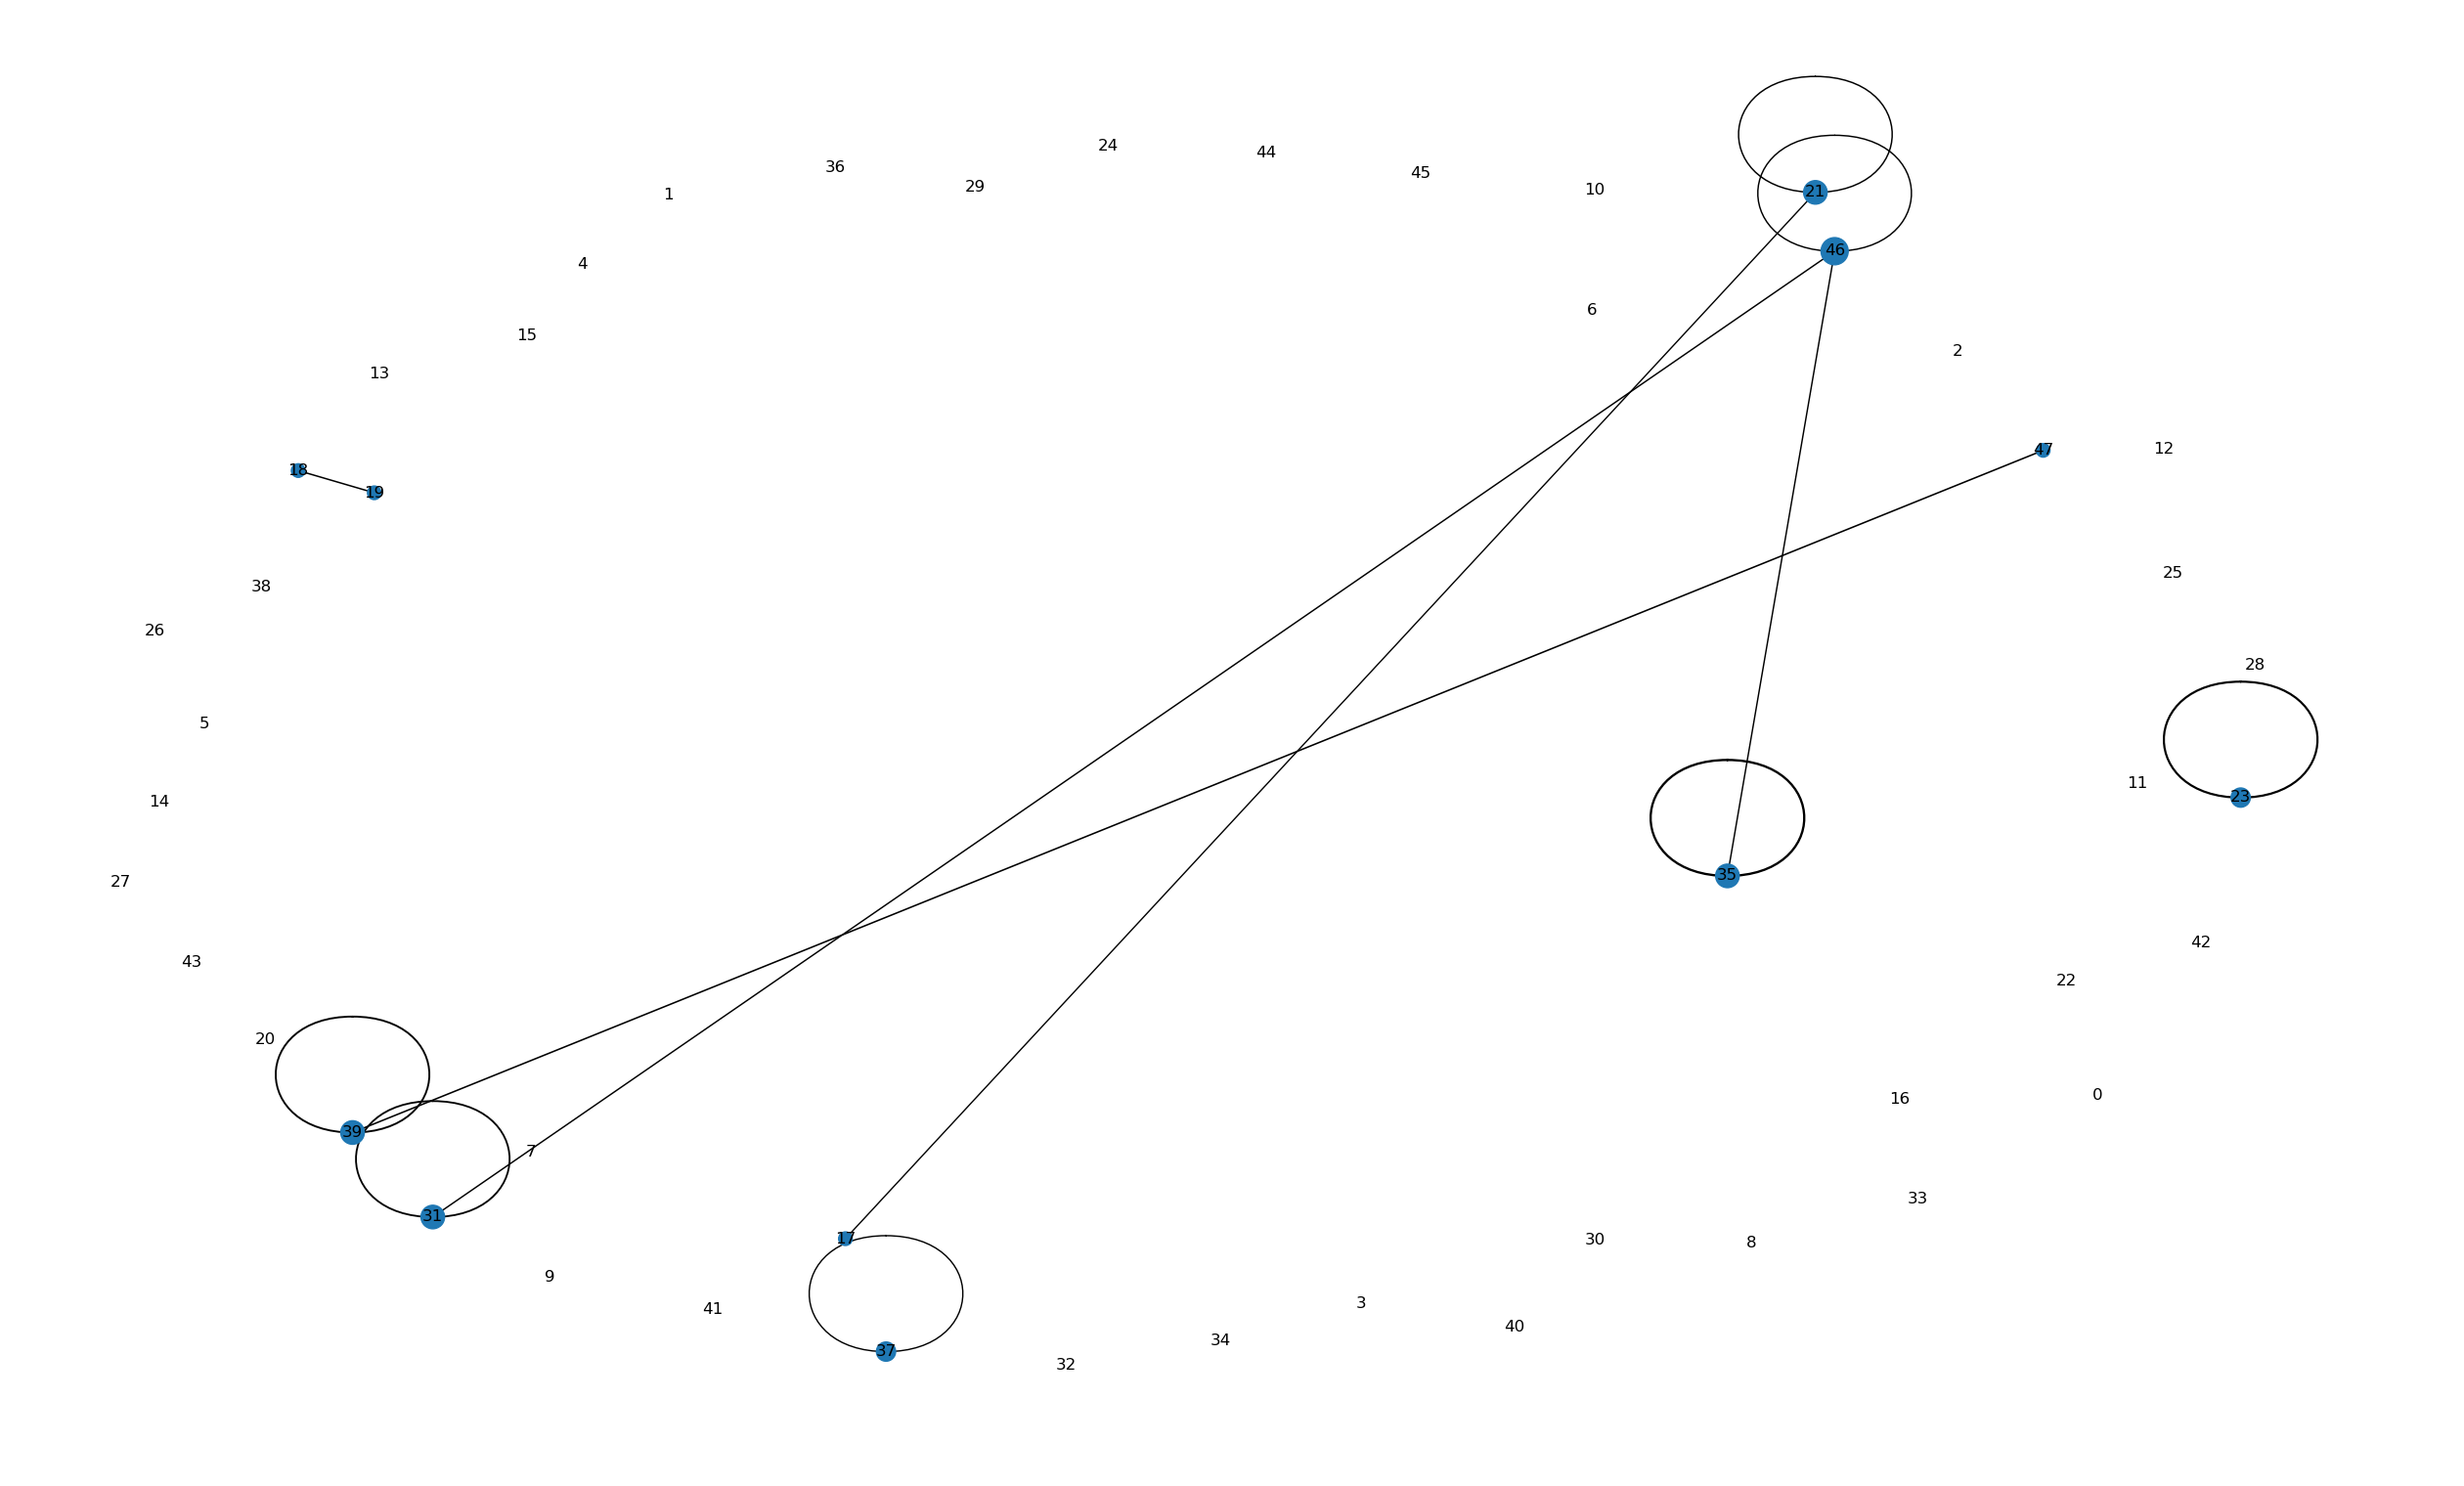

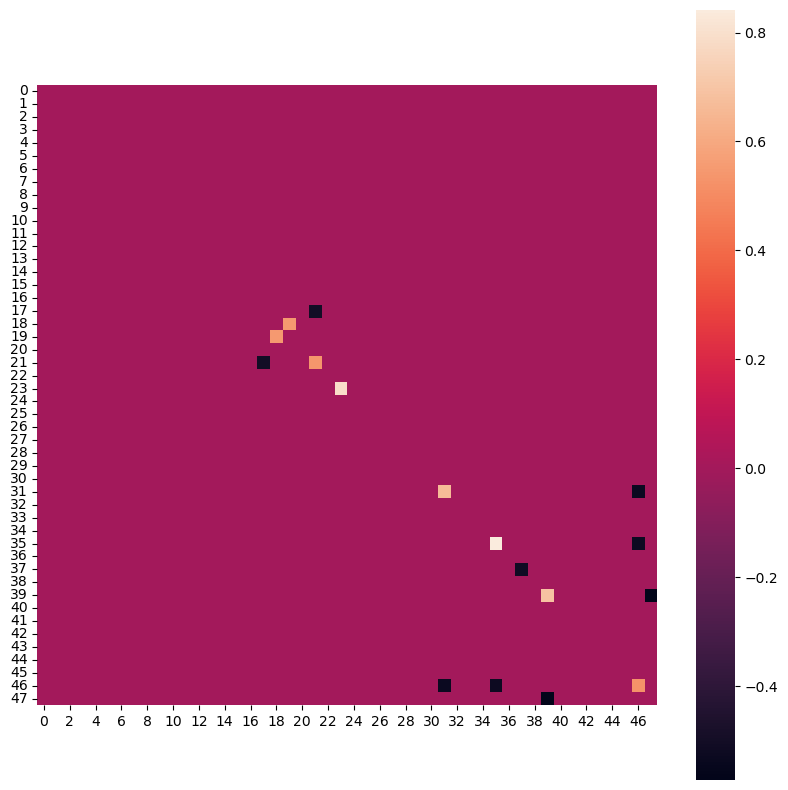

In [9]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import input_data, datasets
from nilearn.connectome import ConnectivityMeasure
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the CSV file
csv_file = pd.read_csv(r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")

# Replace labels 1 and 2 with 0 and 1
csv_file['DX_GROUP'].replace({1: 0, 2: 1}, inplace=True)

# Split data into training and test sets
train_df, test_df = train_test_split(csv_file, test_size=0.2, random_state=42)

# Load the Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
masker = input_data.NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)

# MRI file directory
mri_dir = r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/cpac/nofilt_noglobal/"

# Placeholder for Graph Neural Network Data
graph_data_list = []

# Placeholder for time_series of all subjects
time_series_all_subjects = []
labels_all_subjects = []

for idx, row in enumerate(train_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        # Store time series and corresponding label for all subjects
        time_series_all_subjects.append(time_series)
        labels_all_subjects.append(row.DX_GROUP)
    except FileNotFoundError:
        pass

# Create an adjacency matrix based on ROI correlations
correlation_measure = ConnectivityMeasure(kind='tangent')
correlation_matrices = correlation_measure.fit_transform(time_series_all_subjects)

for idx, correlation_matrix in enumerate(correlation_matrices):

    # Threshold the correlation matrix (optional)
    threshold = 0.5  # Set the threshold value for the correlation
    correlation_matrix[abs(correlation_matrix) < threshold] = 0

    # Generate graph from correlation matrix
    G = nx.from_numpy_matrix(correlation_matrix)

    if idx == 0:  # Only for the first iteration
        print(correlation_matrix)

        # Step 6: Visualize the graph
        plt.figure(figsize=(25, 15))  # Increase the size of the plot
        pos = nx.spring_layout(G)  # Use spring layout
        node_sizes = [100 * np.abs(G.degree(n)) for n in G.nodes]  # Size nodes by their degree
        edge_widths = [2 * np.abs(G[u][v]['weight']) for u, v in G.edges]  # Width edges by their weight
        nx.draw(G, pos, node_size=node_sizes, width=edge_widths, with_labels=True)
        plt.show()

        # Plot the correlation matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(correlation_matrix, square=True)
        plt.show()

    # Generate edges and features for PyTorch Geometric
    edge_index = torch.tensor(list(G.edges), dtype=torch.long)
    x = torch.tensor(time_series_all_subjects[idx], dtype=torch.float)
    y = torch.tensor([labels_all_subjects[idx]], dtype=torch.float)

    # Create graph data for PyTorch Geometric
    data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

    # Append data to list
    graph_data_list.append(data)


In [12]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine the number of features and classes
num_features = graph_data_list[0].num_node_features
num_classes = 2  # Autistic and non-autistic

# Instantiate the model and optimizer
model = Net(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create a data loader
loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

# Model Training
for epoch in range(100):
    total_loss = 0
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

# Model Evaluation
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    _, pred = model(data).max(dim=1)
    correct += int((pred == data.y.long()).sum())
print('Accuracy: {:.4f}'.format(correct/len(loader.dataset)))


Epoch: 1, Loss: 0.7013292448087172
Epoch: 2, Loss: 0.6870256147601388
Epoch: 3, Loss: 0.688361173326319
Epoch: 4, Loss: 0.6625827984376387
Epoch: 5, Loss: 0.6592637435956434
Epoch: 6, Loss: 0.6296367726542733
Epoch: 7, Loss: 0.613410543311726
Epoch: 8, Loss: 0.6052464626052163
Epoch: 9, Loss: 0.5906116420572455
Epoch: 10, Loss: 0.5813569521362131
Epoch: 11, Loss: 0.5549079857089303
Epoch: 12, Loss: 0.5598296875303442
Epoch: 13, Loss: 0.5562518347393383
Epoch: 14, Loss: 0.5664357813921842
Epoch: 15, Loss: 0.5649565661495383
Epoch: 16, Loss: 0.5344030152667653
Epoch: 17, Loss: 0.5750163143331354
Epoch: 18, Loss: 0.5471295565366745
Epoch: 19, Loss: 0.5190409814769571
Epoch: 20, Loss: 0.516132109544494
Epoch: 21, Loss: 0.5104217569936406
Epoch: 22, Loss: 0.5345930389382623
Epoch: 23, Loss: 0.5204284692352469
Epoch: 24, Loss: 0.5469371649351987
Epoch: 25, Loss: 0.5268821160901677
Epoch: 26, Loss: 0.5076610445976257
Epoch: 27, Loss: 0.47295446964827453
Epoch: 28, Loss: 0.4982218810103156
Epo

Test Accuracy: 0.5376


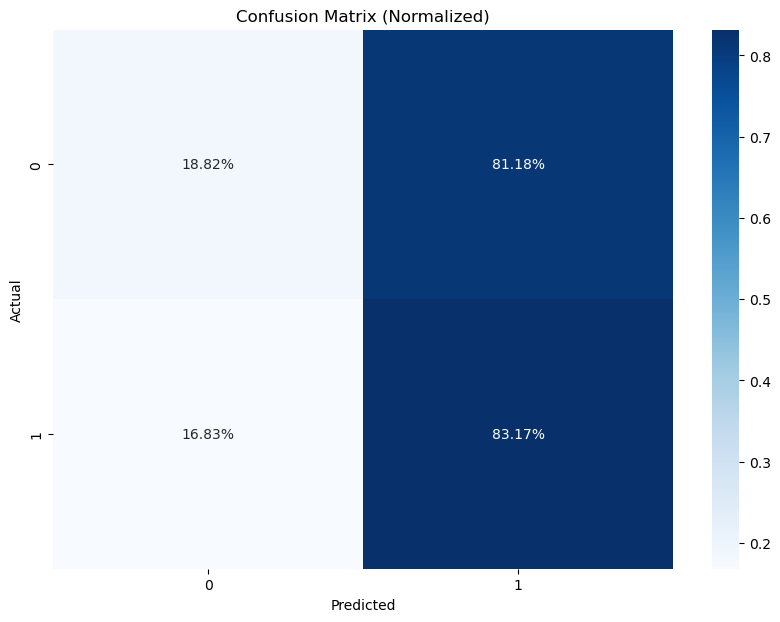

     Actual  Predicted
0       0.0          1
1       1.0          1
2       1.0          1
3       0.0          0
4       1.0          1
..      ...        ...
181     0.0          1
182     1.0          1
183     1.0          0
184     1.0          0
185     1.0          1

[186 rows x 2 columns]
              precision    recall  f1-score   support

Non-Autistic       0.48      0.19      0.27        85
    Autistic       0.55      0.83      0.66       101

    accuracy                           0.54       186
   macro avg       0.52      0.51      0.47       186
weighted avg       0.52      0.54      0.48       186



In [13]:
# Placeholder for time series data
time_series_list = []

for idx, row in enumerate(test_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        # Append time series to list
        time_series_list.append(time_series)
    except FileNotFoundError:
        pass

# Create an adjacency matrix based on ROI correlations
correlation_measure = ConnectivityMeasure(kind='tangent')
tangent_matrices = correlation_measure.fit_transform(time_series_list)

# Placeholder for Graph Neural Network Data for testing
graph_data_test_list = []

for idx, (row, tangent_matrix) in enumerate(zip(test_df.itertuples(), tangent_matrices)):
    # Threshold the tangent matrix (optional)
    threshold = 0.5  # Set the threshold value for the correlation
    tangent_matrix[abs(tangent_matrix) < threshold] = 0

    # Generate graph from tangent matrix
    G = nx.from_numpy_matrix(tangent_matrix)

    # Generate edges and features for PyTorch Geometric
    edge_index = torch.tensor(list(G.edges), dtype=torch.long)
    x = torch.tensor(time_series_list[idx], dtype=torch.float)
    y = torch.tensor([row.DX_GROUP], dtype=torch.float)

    # Create graph data for PyTorch Geometric
    data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

    # Append data to list
    graph_data_test_list.append(data)

# Create a data loader for testing data
test_loader = DataLoader(graph_data_test_list, batch_size=32, shuffle=False)

# Testing
model.eval()
correct = 0
all_preds = []
all_labels = []

for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        _, pred = output.max(dim=1)
    all_preds.append(pred.cpu().numpy())
    all_labels.append(data.y.cpu().numpy())
    correct += int((pred == data.y.long()).sum())

accuracy = correct / len(test_loader.dataset)

print(f'Test Accuracy: {accuracy:.4f}')

# Flatten the list of predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

'''cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# Print actual vs predicted
actual_vs_predicted = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds})
print(actual_vs_predicted)


# Classification report
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic']))


GCN - Epoch: 1, Loss: 0.7196722599593076
GCN - Epoch: 2, Loss: 0.7013367820869792
GCN - Epoch: 3, Loss: 0.6890799078074369
GCN - Epoch: 4, Loss: 0.6923537742007863
GCN - Epoch: 5, Loss: 0.688620234077627
GCN - Epoch: 6, Loss: 0.6789203719659285
GCN - Epoch: 7, Loss: 0.6573401554064318
GCN - Epoch: 8, Loss: 0.6481567350300875
GCN - Epoch: 9, Loss: 0.6592379889704965
GCN - Epoch: 10, Loss: 0.6275483044711027
GCN - Epoch: 11, Loss: 0.6087615097110922
GCN - Epoch: 12, Loss: 0.60036224397746
GCN - Epoch: 13, Loss: 0.6016800999641418
GCN - Epoch: 14, Loss: 0.589893870733001
GCN - Epoch: 15, Loss: 0.592031026428396
GCN - Epoch: 16, Loss: 0.5744209560480985
GCN - Epoch: 17, Loss: 0.5714636201208289
GCN - Epoch: 18, Loss: 0.5568401041356
GCN - Epoch: 19, Loss: 0.5691146390004591
GCN - Epoch: 20, Loss: 0.5386522696776823
GCN - Epoch: 21, Loss: 0.5434019443663684
GCN - Epoch: 22, Loss: 0.5293414213440635
GCN - Epoch: 23, Loss: 0.5089502822269093
GCN - Epoch: 24, Loss: 0.5287258340553804
GCN - Epo

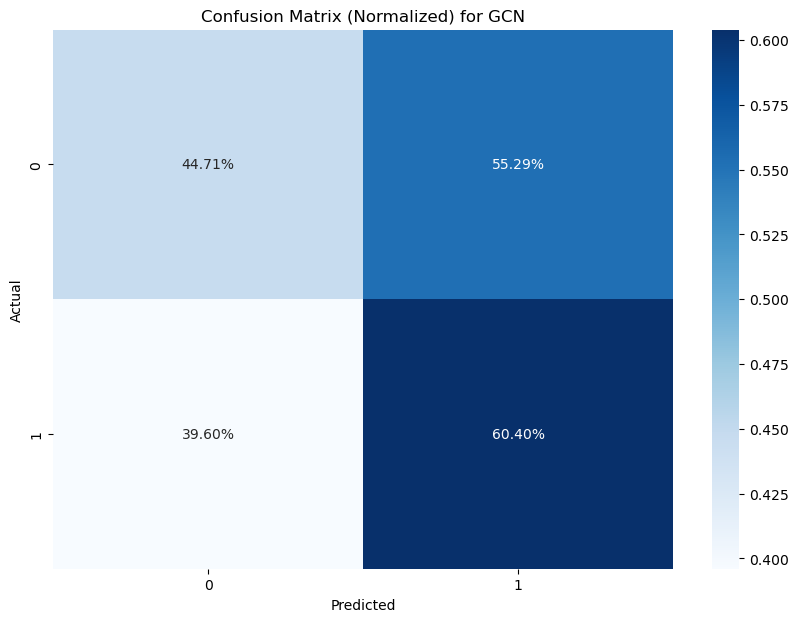

GAT - Epoch: 1, Loss: 0.6994860659946095
GAT - Epoch: 2, Loss: 0.6909019134261392
GAT - Epoch: 3, Loss: 0.6889822130853479
GAT - Epoch: 4, Loss: 0.6859046058221296
GAT - Epoch: 5, Loss: 0.681607725945386
GAT - Epoch: 6, Loss: 0.6699546765197407
GAT - Epoch: 7, Loss: 0.6571962047706951
GAT - Epoch: 8, Loss: 0.6381565874273126
GAT - Epoch: 9, Loss: 0.6323833546855233
GAT - Epoch: 10, Loss: 0.6418160227212039
GAT - Epoch: 11, Loss: 0.614512866193598
GAT - Epoch: 12, Loss: 0.5890717587687753
GAT - Epoch: 13, Loss: 0.5836982469667088
GAT - Epoch: 14, Loss: 0.566132518378171
GAT - Epoch: 15, Loss: 0.5836805579337206
GAT - Epoch: 16, Loss: 0.5744137398221276
GAT - Epoch: 17, Loss: 0.5646397119218652
GAT - Epoch: 18, Loss: 0.5790275186300278
GAT - Epoch: 19, Loss: 0.5492886020378633
GAT - Epoch: 20, Loss: 0.5465376065535978
GAT - Epoch: 21, Loss: 0.5763242678208784
GAT - Epoch: 22, Loss: 0.5388719006018206
GAT - Epoch: 23, Loss: 0.5220005227760836
GAT - Epoch: 24, Loss: 0.5618863606994803
GAT 

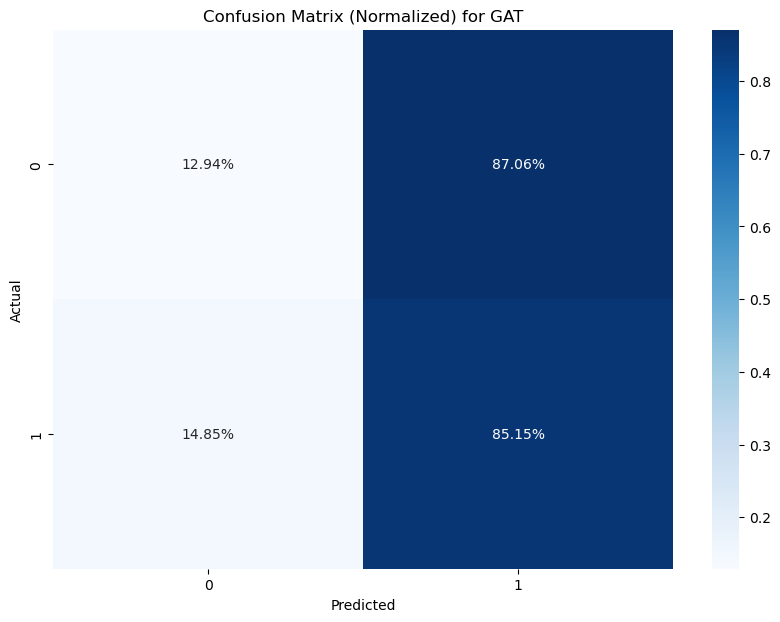

SAGE - Epoch: 1, Loss: 0.6982619979164817
SAGE - Epoch: 2, Loss: 0.689156792380593
SAGE - Epoch: 3, Loss: 0.6849536516449668
SAGE - Epoch: 4, Loss: 0.694272602146322
SAGE - Epoch: 5, Loss: 0.6847545043988661
SAGE - Epoch: 6, Loss: 0.6701500415802002
SAGE - Epoch: 7, Loss: 0.6719086116010492
SAGE - Epoch: 8, Loss: 0.6500133384357799
SAGE - Epoch: 9, Loss: 0.6485629677772522
SAGE - Epoch: 10, Loss: 0.623923353173516
SAGE - Epoch: 11, Loss: 0.6191392270001498
SAGE - Epoch: 12, Loss: 0.600943310694261
SAGE - Epoch: 13, Loss: 0.5880527631802992
SAGE - Epoch: 14, Loss: 0.5597699758681384
SAGE - Epoch: 15, Loss: 0.5509148321368478
SAGE - Epoch: 16, Loss: 0.5670937231995843
SAGE - Epoch: 17, Loss: 0.5677402629093691
SAGE - Epoch: 18, Loss: 0.5570875379172239
SAGE - Epoch: 19, Loss: 0.559191954406825
SAGE - Epoch: 20, Loss: 0.5685845058072697
SAGE - Epoch: 21, Loss: 0.5280273434790698
SAGE - Epoch: 22, Loss: 0.5097908987240358
SAGE - Epoch: 23, Loss: 0.5482807701284235
SAGE - Epoch: 24, Loss: 0

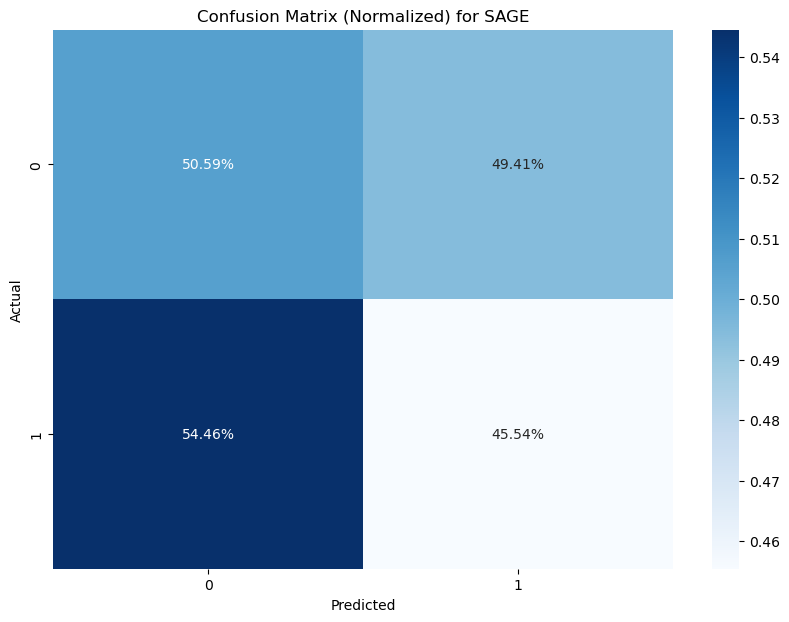

GIN - Epoch: 1, Loss: 0.6963628124107014
GIN - Epoch: 2, Loss: 0.6935932311144742
GIN - Epoch: 3, Loss: 0.694865183396773
GIN - Epoch: 4, Loss: 0.6932530863718553
GIN - Epoch: 5, Loss: 0.6935361894694242
GIN - Epoch: 6, Loss: 0.6922451907938177
GIN - Epoch: 7, Loss: 0.6928870352831754
GIN - Epoch: 8, Loss: 0.6931351016868245
GIN - Epoch: 9, Loss: 0.692801749164408
GIN - Epoch: 10, Loss: 0.6938350173560056
GIN - Epoch: 11, Loss: 0.6917670531706377
GIN - Epoch: 12, Loss: 0.6927180940454657
GIN - Epoch: 13, Loss: 0.6931063668294386
GIN - Epoch: 14, Loss: 0.6908448013392362
GIN - Epoch: 15, Loss: 0.6912856589664113
GIN - Epoch: 16, Loss: 0.6926678798415444
GIN - Epoch: 17, Loss: 0.6891397075219587
GIN - Epoch: 18, Loss: 0.6910295974124562
GIN - Epoch: 19, Loss: 0.6828044138171456
GIN - Epoch: 20, Loss: 0.6606317054141652
GIN - Epoch: 21, Loss: 0.6457983607595618
GIN - Epoch: 22, Loss: 0.6172063567421653
GIN - Epoch: 23, Loss: 0.6406723233786497
GIN - Epoch: 24, Loss: 0.6312900321050123
GIN

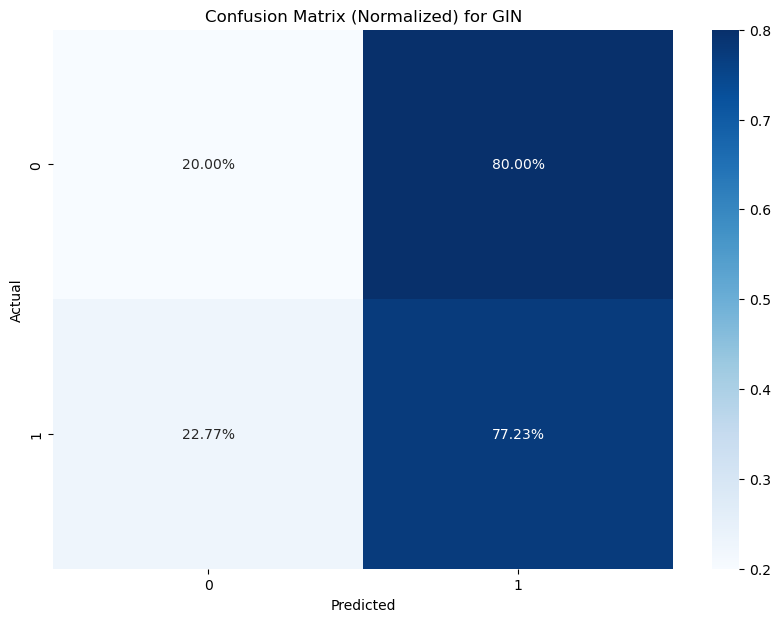

  Model  Train_Accuracy  Test_Accuracy  Precision    Recall  F1-Score
0   GCN        0.937226       0.532258   0.525997  0.525510  0.524995
1   GAT        0.779562       0.521505   0.480288  0.490448  0.428601
2  SAGE        0.929927       0.478495   0.480751  0.480664  0.478359
3   GIN        0.852555       0.510753   0.479623  0.486139  0.451789


In [14]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.data import DataLoader
import pandas as pd

class Net(torch.nn.Module):
    def __init__(self, conv_layer, num_node_features, num_classes):
        super(Net, self).__init__()
        if conv_layer == GINConv:
            nn1 = torch.nn.Sequential(torch.nn.Linear(num_node_features, 16), torch.nn.ReLU(), torch.nn.Linear(16, 16))
            self.conv1 = conv_layer(nn1)
            nn2 = torch.nn.Sequential(torch.nn.Linear(16, 32), torch.nn.ReLU(), torch.nn.Linear(32, 32))
            self.conv2 = conv_layer(nn2)
        else:
            self.conv1 = conv_layer(num_node_features, 16)
            self.conv2 = conv_layer(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    
# Define models and their names
models = [GCNConv, GATConv, SAGEConv, GINConv]
model_names = ['GCN', 'GAT', 'SAGE', 'GIN']

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy"])


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy", "Precision", "Recall", "F1-Score"])

# Model Training and Evaluation for each Convolution Layer
for model_name, model_class in zip(model_names, models):
    model = Net(model_class, num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training
    for epoch in range(100):
        total_loss = 0
        model.train()
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'{model_name} - Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

    # Evaluation on Training Data
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        _, pred = model(data).max(dim=1)
        correct += int((pred == data.y.long()).sum())
    train_accuracy = correct / len(loader.dataset)
    print(f'{model_name} Train Accuracy: {train_accuracy:.4f}')

    # Evaluation on Test Data
    correct = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            _, pred = output.max(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
        correct += int((pred == data.y.long()).sum())
    test_accuracy = correct / len(test_loader.dataset)
    print(f'{model_name} Test Accuracy: {test_accuracy:.4f}')

    # Flatten the list of predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Normalized) for {model_name}')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic'], output_dict=True)

    # Append the accuracy to the results DataFrame
    results = results.append({
        "Model": model_name,
        "Train_Accuracy": train_accuracy,
        "Test_Accuracy": test_accuracy,
        "Precision": report['macro avg']['precision'],
        "Recall": report['macro avg']['recall'],
        "F1-Score": report['macro avg']['f1-score'],
    }, ignore_index=True)

print(results)



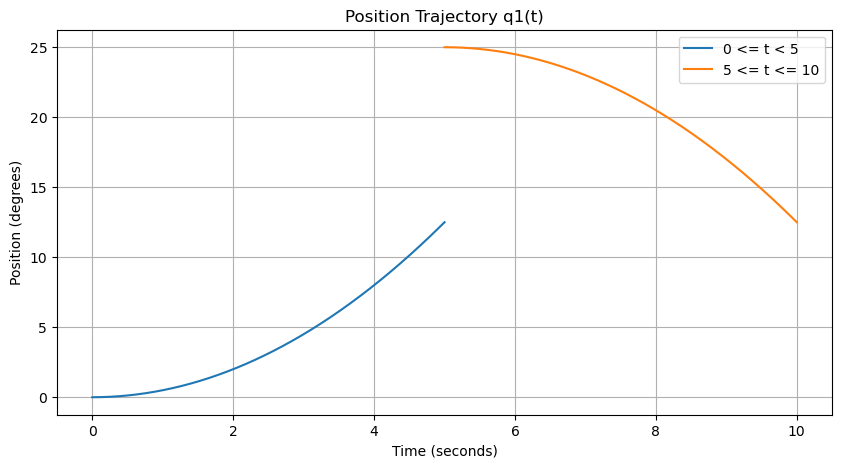

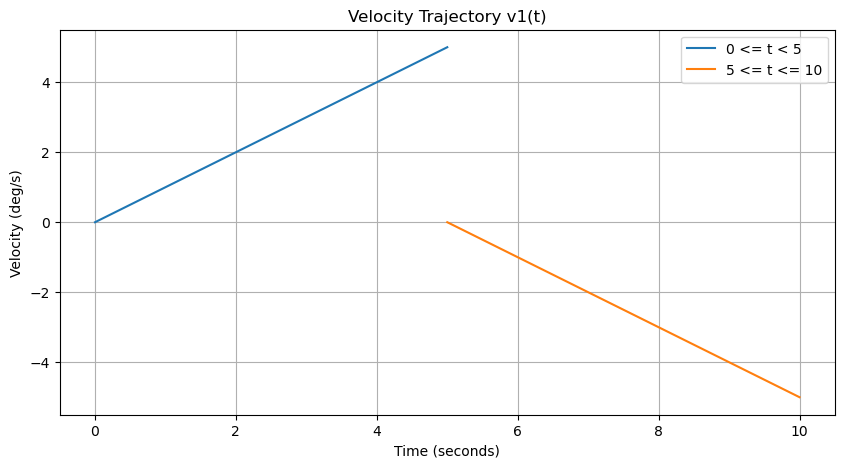

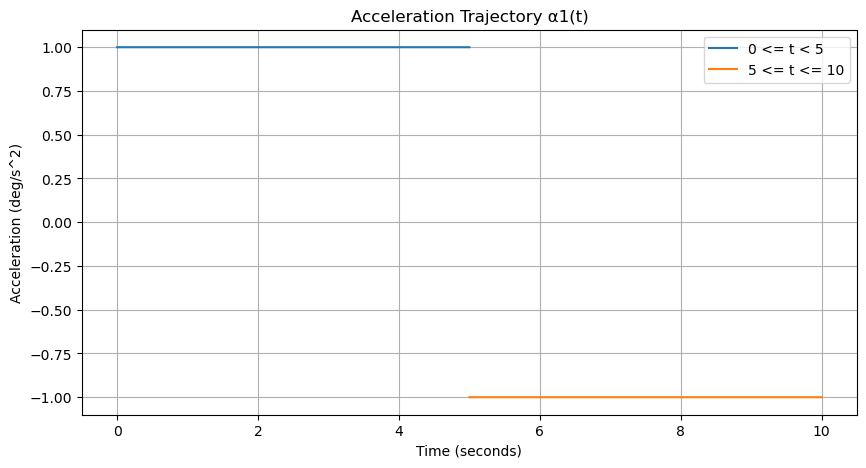

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Time intervals
t1 = np.linspace(0, 5, 50000)
t2 = np.linspace(5, 10, 50000)

# Position trajectories
q1_t1 = 0.5 * t1**2
q1_t2 = 25 - 0.5 * (t2 - 5)**2

# Velocity trajectories
v1_t1 = t1
v1_t2 = 5 - t2

# Acceleration trajectories
a1_t1 = np.ones_like(t1)
a1_t2 = -np.ones_like(t2)

# Plot position
plt.figure(figsize=[10, 5])
plt.plot(t1, q1_t1, label='0 <= t < 5')
plt.plot(t2, q1_t2, label='5 <= t <= 10')
plt.title('Position Trajectory q1(t)')
plt.xlabel('Time (seconds)')
plt.ylabel('Position (degrees)')
plt.legend()
plt.grid()
plt.show()

# Plot velocity
plt.figure(figsize=[10, 5])
plt.plot(t1, v1_t1, label='0 <= t < 5')
plt.plot(t2, v1_t2, label='5 <= t <= 10')
plt.title('Velocity Trajectory v1(t)')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (deg/s)')
plt.legend()
plt.grid()
plt.show()

# Plot acceleration
plt.figure(figsize=[10, 5])
plt.plot(t1, a1_t1, label='0 <= t < 5')
plt.plot(t2, a1_t2, label='5 <= t <= 10')
plt.title('Acceleration Trajectory α1(t)')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (deg/s^2)')
plt.legend()
plt.grid()
plt.show()


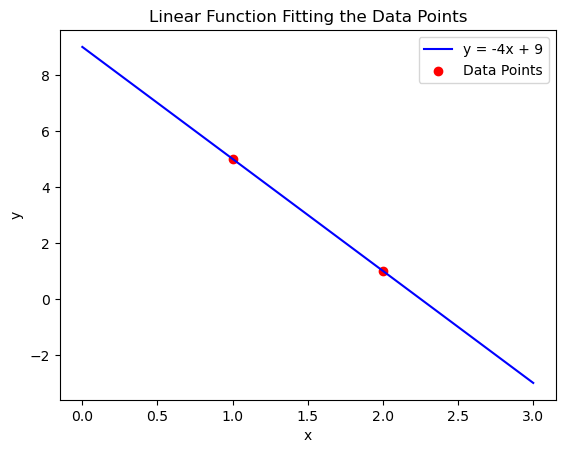

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Given data points
x_points = [1, 2]
y_points = [5, 1]

# Define the linear function y = -4x + 9
def linear_function(x):
    return -4 * x + 9

# Generate x values
x_values = np.linspace(0, 3, 100)

# Compute the corresponding y values
y_values = linear_function(x_values)

# Plot the linear function
plt.plot(x_values, y_values, label='y = -4x + 9', color='blue')

# Plot the given data points
plt.scatter(x_points, y_points, color='red', label='Data Points')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Function Fitting the Data Points')
plt.legend()

# Show the plot
plt.show()


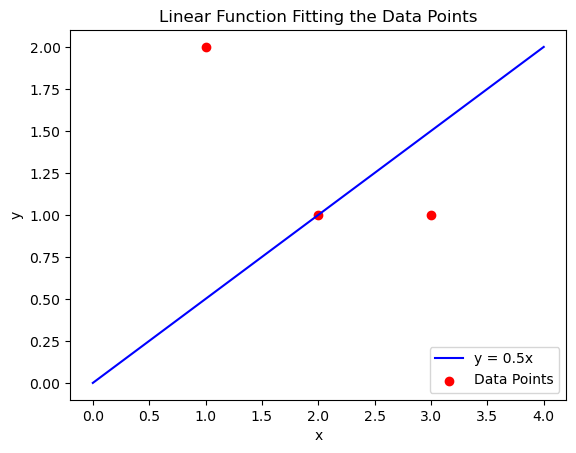

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Given data points
x_points = [1, 2, 3]
y_points = [2, 1, 1]

# Define the linear function y = 0.5x
def linear_function(x):
    return 0.5 * x

# Generate x values
x_values = np.linspace(0, 4, 100)

# Compute the corresponding y values
y_values = linear_function(x_values)

# Plot the linear function
plt.plot(x_values, y_values, label='y = 0.5x', color='blue')

# Plot the given data points
plt.scatter(x_points, y_points, color='red', label='Data Points')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Function Fitting the Data Points')
plt.legend()

# Show the plot
plt.show()
